# Deep learning assessment

The following notebook develops and compares 2 CNN models which are able to clasfiffy images with a cell nuclei in the centre of the image into 4 categories:
 
1. Normal epithelial cell nuclei with label 0.
2. Cancer epithelial cell nuclei with label 1.
3. Muscle cell nuclei with label 2.
4. Immune leukocyte cell nuclei with label 3.

## Import dependecies


In [147]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from skimage import io, transform
import datetime
import collections

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, datasets

from PIL import Image

import copy
import time
import os
import shutil

# For ray-tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
from torch.utils.data import random_split
# Input data files are available in the read-only "../input/" director

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Inspect the data

The data provided consists of a set of 100x100 pixel images with coresponding csv files provided the labels. There are 7560 training samples and 5041 testing samples. A pandas dataframe is created with the fields `'Filename'` and `'Label'`.

In [148]:


train_data = pd.read_csv('kaggle/input/deep-learning-for-msc-2022-23/train.csv')
print(f'Data contains: {len(train_data)} samples')
print(train_data.head())

Data contains: 7560 samples
  Filename  Label
0    1.png      0
1    2.png      0
2    3.png      0
3    4.png      0
4    5.png      0


In [149]:
example_data = pd.read_csv("kaggle/input/deep-learning-for-msc-2022-23/example.csv")

print(len(example_data))
example_data.head()

5041


,Filename,Label
0,10001.png,0
1,10002.png,0
2,10003.png,0
3,10004.png,0
4,10005.png,0


In [150]:
img_name = train_data['Filename'].iloc[0]
Label = train_data['Label'].iloc[0]
print(img_name)
print(Label)

img = io.imread(r'kaggle\input\deep-learning-for-msc-2022-23\train\\'+img_name)

1.png
0


## Display image

A helper function is made to display images with the coresponding label.

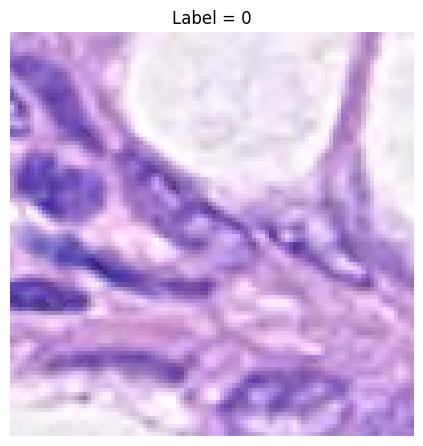

In [151]:
def show_Label(image,Label):
    """Show image with Label"""
    plt.imshow(image)
    plt.title(f'Label = {Label}')
    plt.tight_layout()
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_Label(io.imread(os.path.join('kaggle/input/deep-learning-for-msc-2022-23/train/', img_name)), Label)
plt.show()

## Dataset class

A custom dataset class is created which inherits from the ``torch.utils.data.Dataset`` class and overides the following methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can be used to get $i^{th}$ sample.

The csv is read in the ``__init__`` but leaves reading of images to
``__getitem__`` which is memory efficient as not all images are stored in the memory but rather read as required.

The sample of the dataset will be a dict ``{'image': image, 'Label': Label}``


The dataset will also take an optional argument ``transform`` so that any required processing can be
applied on the sample.

In [152]:
class labeledDataset(Dataset):
    """Face Label dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imgs = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.imgs['Filename'].iloc[idx])
        
        image = io.imread(img_name)
        Label = self.imgs['Label'].iloc[idx]
        
        if self.transform:
            image = self.transform(image)
            Label = torch.tensor(Label)
        
        sample = {'image': image, 'Label': Label}

        # if self.transform:
        #     sample = self.transform(sample)

        return sample

0 (100, 100, 3) 0


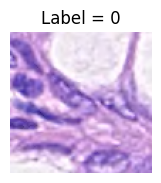

1 (100, 100, 3) 0


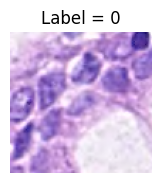

2 (100, 100, 3) 0


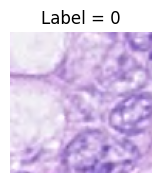

3 (100, 100, 3) 0


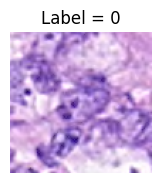

In [153]:
labled_dataset = labeledDataset(csv_file=r'kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                    root_dir=r'kaggle/input/deep-learning-for-msc-2022-23/train')

fig = plt.figure()

for i in range(len(labled_dataset)):
    sample = labled_dataset[i]
    print(i, sample['image'].shape, sample['Label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i) +' with Label ' +f'{Label}')
    ax.axis('off')
    show_Label(**sample)

    if i == 3:
        plt.show()
        break

## Constructing datasets
2 datasets are constructed:
- training set
- test set

**Data augmentation** is used in the training set to provide more variation within the set. This is done using `torchvision.transforms` package. The images are first converted to tensors then resized and finaly a random crop is applied.

The `torch.utils.data.DataLoader` is then used to load the data. A train and test loader are constructed where train set has a batch size of 4 and train loader with batch size of 1 as it is only used for validation.

In [154]:
transfomations = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize(100),
                                    transforms.RandomCrop(64)
                                    ])

train_dataset = labeledDataset(csv_file=r'kaggle\input\deep-learning-for-msc-2022-23\train.csv',
                                           root_dir=r'kaggle\input\deep-learning-for-msc-2022-23\train',
                                           transform=transfomations)

val_dataset  = labeledDataset(csv_file=r'kaggle\input\deep-learning-for-msc-2022-23\example.csv',
                                           root_dir=r'kaggle\input\deep-learning-for-msc-2022-23\test',
                                           transform=None)




for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].size(), sample['Label'])

    if i == 3:
        break

0 torch.Size([3, 64, 64]) tensor(0)
1 torch.Size([3, 64, 64]) tensor(0)
2 torch.Size([3, 64, 64]) tensor(0)
3 torch.Size([3, 64, 64]) tensor(0)


In [155]:
train_loader = DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

val_loader = DataLoader(val_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_batch(sample_batched):
    """Show image with Label for a batch of samples."""
    images_batch, Label_batch = \
            sample_batched['image'], sample_batched['Label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from train_loader')

0 torch.Size([4, 3, 64, 64]) torch.Size([4])
1 torch.Size([4, 3, 64, 64]) torch.Size([4])
2 torch.Size([4, 3, 64, 64]) torch.Size([4])
3 torch.Size([4, 3, 64, 64]) torch.Size([4])


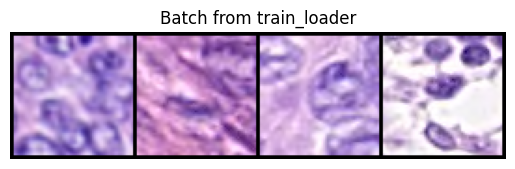

In [156]:
if __name__ == '__main__':
    for i_batch, sample_batched in enumerate(train_loader):
        print(i_batch, sample_batched['image'].size(),
            sample_batched['Label'].size())

        # observe 4th batch and stop.
        if i_batch == 3:
            plt.figure()
            show_batch(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break

## Build the networks

Both models used are CNNs. The first is constructed using 2 2D convolutional layrs with kernel size of 3 and the secodnd is based on imageNet.

This is all from lab 3 which discusses how to build a convolutional neural network.

64(channels)x64x64(img dimensions)/4(max pooling) = 65536

whish is used in the linear layer

### First model

In [157]:
model = nn.Sequential(collections.OrderedDict([
          ('conv1', nn.Conv2d(3,10,3,padding=1)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(10,13,3,padding=1)),
          ('relu2', nn.ReLU()),
          ('pool1',nn.MaxPool2d(2,2)),

          ('flatten', nn.Flatten()),                                          
          ('fc1', nn.Linear(13312,100)),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(100,5)),
        ]))



### Second model

In [158]:
root = r'kaggle\input\deep-learning-for-msc-2022-23'

data = pd.read_csv(root+r'\train.csv')

In [159]:
def train_test_split(df, frac=0.2):
    
    # get random sample 
    test = df.sample(frac=frac, axis=0)

    # get everything but the test sample
    train = df.drop(index=test.index)

    return train, test

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [160]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'sortedData/'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

image_datasets = {'train': train_dataset,'val':val_dataset}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [0,1,2,3]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [161]:
print(image_datasets['train'])
print(dataloaders['train'])

print(labled_dataset)
print(train_loader)


In [162]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\Users\OEM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\OEM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training


In [163]:
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for item in train_loader:
            imgs=item['image']
            labels = item['Label']
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for item in test_loader:
            data=item['image']
            target = item['Label']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [164]:
def finetune_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [165]:
# model_ft = finetune_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

In [166]:


lr = 0.01

# we set the optimiser as Stochastic Gradient Descent for both networks, 
# you could also try Adam
optimizer = optim.SGD(model.parameters(), lr=lr)

#optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer_dense = optim.Adam(model_dense.parameters(), lr=lr)

# set the loss function to optimise. Cross Entropy is usually the best for 
# classification
loss_fn = nn.CrossEntropyLoss()

In [167]:
# n_epochs = 1
# use_cuda = True
# device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# # train the CNN
# training_loop(
#     n_epochs = n_epochs, 
#     optimizer = optimizer,
#     model = model, 
#     device = device,
#     loss_fn = loss_fn,
#     train_loader = train_loader,
# )


In [168]:
# test_loop(model = model, device = device, test_loader = test_loader)

## Ray Tune Hyperparameter Tuning

The following is a configurable model.

In [169]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


    trainset = labeledDataset(csv_file=r'kaggle\input\deep-learning-for-msc-2022-23\train.csv',
                                           root_dir=r'kaggle\input\deep-learning-for-msc-2022-23\train',
                                           transform=transfomations)

    testset  = labeledDataset(csv_file=r'kaggle\input\deep-learning-for-msc-2022-23\example.csv',
                                           root_dir=r'kaggle\input\deep-learning-for-msc-2022-23\test',
                                           transform=None)

    return trainset, testset

In [170]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,10,3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [171]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [172]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [173]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath(r"kaggle\input\deep-learning-for-msc-2022-23\train")
    load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=3, max_num_epochs=10, gpus_per_trial=0)

2023-03-21 17:36:10,540	INFO tune.py:922 -- Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.


OSError: [Errno 203] AssignProcessToJobObject() failed